# Newton's Method

This notebook explores Newton's method in the context of finding local minima of the loss function in linear regression task. It uses the same dataset as the gradient descent example.

In [54]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import numpy as np

In [55]:
housing = fetch_california_housing()
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [56]:
m = 5000  # Number of points to use

income = housing.data[:m, 0]
price = housing.target[:m]

Newton's method is concerned with finding $\theta$ such that $f(\theta) = 0$.

1. Similar to gradient descent, our initial guess $\theta^{(0)}$ is usually random. 
2. We calculate the first-order derivative at $\theta^{(0)}$. And solve for the point $\theta^{(1)}$ where the tangent line intersects with the line $\theta = 0$. In higher dimensions we look where the tangent hyperplane intersects the hyperplane formed by components of $\theta$.
3. We repeat the process with $\theta^{(1)}$, until converges.

Define $\Delta = \theta^{(0)} - \theta^{(1)}$. Then $\theta^{(1)} = \theta^{(0)} - \Delta$.

We know:
$$
f'(\theta^{(0)}) = \frac{f(\theta^{(0)})}{\Delta}
$$

This implies:
$$
\theta^{(1)} = \theta^{(0)} - \frac{f(\theta^{(0)})}{f'(\theta^{(0)})}
$$

And in general:
$$
\theta^{(t + 1)} = \theta^{(t)} - \frac{f(\theta^{(t)})}{f'(\theta^{(t)})}
$$

If we now set $f(\theta)$ to be equal to the derivative $J'(\theta)$ of the objective function, we get a method for finding local minima:
$$
\theta^{(t + 1)} = \theta^{(t)} - \frac{J'(\theta^{(t)})}{J''(\theta^{(t)})}
$$

Finally, in higher dimensions this can be generalized to:
$$
\theta^{(t + 1)} = \theta^{(t)} - H^{-1}\nabla_\theta J(\theta),
$$

where $H$ is the Hessian matrix containing second-order derivatives.
$$
H_{kj} = \frac{\partial^2 J(\theta)}{\partial\theta_k \partial\theta_j}
$$

Convergence in terms of number of iterations in Newton's method is a lot quicker than in gradient descent. However, inverting the Hessian in each iteration quickly becomes expensive with more-and-more dimensions, so each step is not as fast.

This makes Newton's method more suitable for cases where the number of parameters is pretty low.

Notice that the update rule is very similar to that of the gradient descent. The learning rate is not a hyperparameter, but instead it's always equal to $H^{-1}$. Newton's method can also use a stochastic/mini-batch implementation.

In the case of linear regression, we can easily show that:
$$
H_{kj} = \frac{\partial^2 J(\theta)}{\partial\theta_k \partial\theta_j} = \sum_{i = 1}^m x_k^{(i)} x_j^{(i)}
$$

This means that $H = X^T X$.

In [57]:
class Metadata:
	def __init__(self, path, initial_guess, convergence_delta, it, max_iter, batch_size):
		self.path = path
		self.initial_guess = initial_guess
		self.convergence_delta = convergence_delta
		self.max_iter = max_iter
		self.iter = it
		self.batch_size = batch_size

	def __str__(self):
		return f"{self.initial_guess = }\n" \
			+ f"{self.convergence_delta = }\n" \
			+ f"{self.iter = }\n" \
			+ f"{self.max_iter = }\n" \
			+ f"{self.batch_size = }"
			

def newtons_method(X, y, batch_size, initial_guess = None, convergence_delta = 0.00001, max_iter = 10000):
	if initial_guess == None:
		initial_guess = np.atleast_1d(np.zeros(X[0].shape))
		initial_guess[0] = np.mean(y, axis=0)

	initial_guess = np.atleast_1d(initial_guess)
	prev_theta = initial_guess
	theta = initial_guess

	path = []
	path.append(theta)

	n_iter = 0
	while True:
		prev_theta = theta
		learning_rate = inverse_hessian(X)
		theta = prev_theta - learning_rate @ gradient(prev_theta, X, y, batch_size)
		path.append(theta)
		n_iter += 1

		if np.sum(np.abs(prev_theta - theta)) <= convergence_delta or n_iter >= max_iter:
			break

	return theta, Metadata(np.array(path), initial_guess, convergence_delta, n_iter, max_iter, batch_size)


def gradient(theta, X, y, batch_size):
	random_indices = np.random.choice(m, size=batch_size, replace=False)
	X_subset = X[random_indices]
	y_subset = y[random_indices]

	residuals = X_subset @ theta - y_subset
	return X_subset.T @ residuals


def inverse_hessian(X):
	return np.linalg.inv(X.T @ X)

In [58]:
X = np.ones((m, 2))
X[:, 1] = income

y = np.array(price)

batch_size = 10
max_it = 10000

theta, metadata = newtons_method(X, y, m, max_iter=max_it)
theta_minibatch, metadata_minibatch = newtons_method(X, y, batch_size, max_iter=max_it)

In [59]:
def prediction(x, theta):
	return theta[0] + theta[1] * x

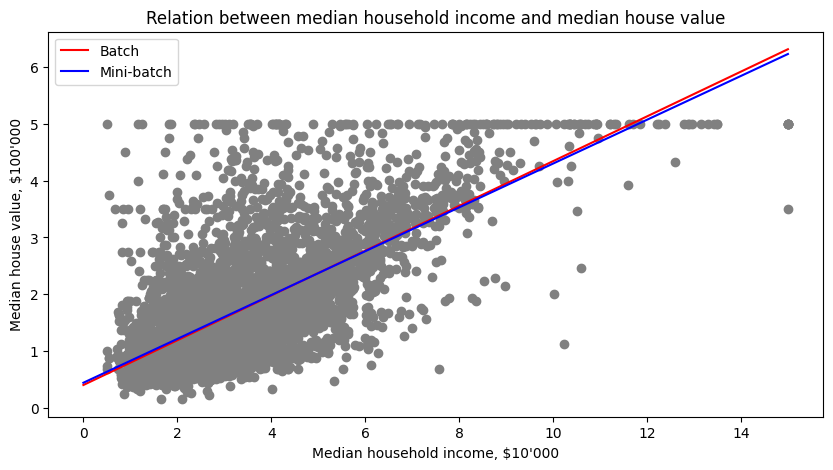

====Batch====
self.initial_guess = array([1.77071724, 0.        ])
self.convergence_delta = 1e-05
self.iter = 2
self.max_iter = 10000
self.batch_size = 5000

====Mini-batch====
self.initial_guess = array([1.77071724, 0.        ])
self.convergence_delta = 1e-05
self.iter = 1652
self.max_iter = 10000
self.batch_size = 10


In [60]:
x_vals = np.arange(np.max(income))
y_vals = prediction(x_vals, theta)
y_vals_minibatch = prediction(x_vals, theta_minibatch)

plt.scatter(income, price, color='gray')
plt.xlabel("Median household income, $10'000")
plt.ylabel("Median house value, $100'000")
plt.title("Relation between median household income and median house value")
plt.plot(x_vals, y_vals, 'r', label="Batch")
plt.plot(x_vals, y_vals_minibatch, 'b', label='Mini-batch')

plt.legend()
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

print("====Batch====")
print(metadata)
print("\n====Mini-batch====")
print(metadata_minibatch)